# Tik-Tok-Channel-Tracker



In diesem Notebook wird eine Methode vorgestellt, um ausgewählte TikTok-Kanäle systematisch zu verfolgen und deren Aktivitäten visuell darzustellen. Ziel ist es, für eine Sammlung interessanter Kanäle sämtliche Veröffentlichungen, Interaktionen und Veränderungen im Zeitverlauf zu erfassen und übersichtlich aufzubereiten.

### Live-Kanalverfolgung
Die vorgestellte Vorgehensweise beinhaltet das Sammeln von Metadaten zu Videos der ausgewählten TikTok-Kanäle mittels automatisierter Skripte. Diese Metadaten umfassen Informationen wie Ansichten, Likes, Kommentare und Reposts. Durch periodisches Ausführen des Sammelprozesses entsteht ein umfangreicher Datensatz, der die Aktivitäten der Kanäle zu verschiedenen Zeitpunkten dokumentiert.

______ 


#### Visuelle Darstellung und Zeitreihenanalyse

Mit Hilfe von Visualisierungstools werden die gesammelten Daten aufbereitet. Diagramme und Grafiken zeigen die Entwicklung der Aktivitätskennzahlen über die Zeit und ermöglichen so den Vergleich von Kanälen sowie das Erkennen von Trends und Mustern. Für jede Visualisierung sind detaillierte Informationen zu einzelnen Videoeinträgen abrufbar.

- Die zeitliche Entwicklung individueller Accounts analysiert.
- Metadaten aller Medieninhalte systematisch erfasst
- Strategien zur Langzeitüberwachung und Auswertung der Aktivitätsdaten



____________

### ausgewählte Kanäle

Diese Methode steht exemplarisch für größe Datensätze zur Auswertung.

#### 67 Tiktok-Kanäle

```text
https://www.tiktok.com/@gereonbollmann
https://www.tiktok.com/@carolin_bachmann_mdb
https://www.tiktok.com/@christinabaumafd
https://www.tiktok.com/@roger_beckamp
https://www.tiktok.com/@renebochmann
https://www.tiktok.com/@brandesdirk
https://www.tiktok.com/@hannesgnauck
https://www.tiktok.com/@gerrithuy
https://www.tiktok.com/@malte.kaufmann
https://www.tiktok.com/@mikemoncsek.de
https://www.tiktok.com/@bernd.schattner.mdb
https://www.tiktok.com/@eugen_schmidt.mdb
https://www.tiktok.com/@janwenzelschmidt
https://www.tiktok.com/@edgar.naujok
https://www.tiktok.com/@joachim.wundrak
https://www.tiktok.com/@kayuweziegler71
https://www.tiktok.com/@dr.rainer.rothfuss
https://www.tiktok.com/@tino.chrupalla.afd
https://www.tiktok.com/@drberndbaumann
https://www.tiktok.com/@brandner_afd
https://www.tiktok.com/@goetzfroemming
https://www.tiktok.com/@enricokomning
https://www.tiktok.com/@muenzenmaier
https://www.tiktok.com/@beatrixvonstorchneu
https://www.tiktok.com/@joernkoenig_mdb
https://www.tiktok.com/@stefan_keuter
https://www.tiktok.com/@karstenhilseafd
https://www.tiktok.com/@marcbernhard
https://www.tiktok.com/@haraldweyel
https://www.tiktok.com/@alice_weidel_afd
https://www.tiktok.com/@rene_springer
https://www.tiktok.com/@sichertdeutschland
https://www.tiktok.com/@janwenzelschmidt
https://www.tiktok.com/@manfred.schiller.afd
https://www.tiktok.com/@ulschzi2
https://www.tiktok.com/@bernd.schattner.mdb
https://www.tiktok.com/@frank.rinck
https://www.tiktok.com/@martin_e_renner
https://www.tiktok.com/@mr_afd
https://www.tiktok.com/@protschkasposition
https://www.tiktok.com/@juergenpohlafd
https://www.tiktok.com/@tmpeterka_mdb
https://www.tiktok.com/@gerold_otten
https://www.tiktok.com/@jan_nolte_bundestag
https://www.tiktok.com/@edgar.naujok
https://www.tiktok.com/@muenzenmaier
https://www.tiktok.com/@volkermuenz_mdb
https://www.tiktok.com/@dr.rainer.kraft
https://www.tiktok.com/@steffenkotre
https://www.tiktok.com/@joernkoenig_mdb
https://www.tiktok.com/@enricokomning
https://www.tiktok.com/@kleinwaechterafd
https://www.tiktok.com/@stefan_keuter
https://www.tiktok.com/@leiferikholm
https://www.tiktok.com/@karstenhilseafd
https://www.tiktok.com/@martin_hess_klartext
https://www.tiktok.com/@jochenhaug_mdb
https://www.tiktok.com/@kaygottschalk
https://www.tiktok.com/@hannesgnauck
https://www.tiktok.com/@albrecht_glaser_mdb
https://www.tiktok.com/@markusfrohnmaier
https://www.tiktok.com/@goetzfroemming
https://www.tiktok.com/@dietmar.friedhoff.mdb
https://www.tiktok.com/@peterfelser_mdb
https://www.tiktok.com/@dr_espendiller
https://www.tiktok.com/@thomas.ehrhorn
https://www.tiktok.com/@gottfriedcurio





_________________

### yt-dlp

**yt-dlp** ist ein Tool zum Herunterladen von Videos oder Metadaten von verschiedenen Websites


```bash
yt-dlp --flat-playlist --dump-single-json https://www.tiktok.com/@goetzfroemming | jq .
```

Das Kommando ruft die Metadaten der TikTok-Playlist des angegebenen Nutzers (**@goetzfroemming**) in komprimierter Form ab, ohne die eigentlichen Videos herunterzuladen (**--flat-playlist**) und gibt sie im JSON-Format aus (**--dump-single-json**). Mit **jq .** werden die JSON-Daten formatiert und übersichtlich angezeigt.

Es wird eine JSON-Datei zurückgegben die viele wertvolle Informationen zu den im Tiktok-Kanal gespeicherten Videos enthält. Wir wollen das haben.

So sieht ein Ausschnitt davon aus:


....

```json
    }
      ],
      "ie_key": "TikTok",
      "_type": "url",
      "url": "https://www.tiktok.com/@goetzfroemming/video/7118684775510019333",
      "__x_forwarded_for_ip": null
    },
    {
      "id": "7117161498392284422",
      "formats": null,
      "subtitles": null,
      "http_headers": {
        "Referer": "https://www.tiktok.com/@goetzfroemming/video/7117161498392284422"
      },
      "channel": "Dr. Götz Frömming",
      "channel_id": "MS4wLjABAAAAH9ePnlsV7vniDNqjkTQazED0ZAVMMCl5QjI62JrIAZnxNMB0FsnvV0Ds4yL1TJnE",
      "uploader": "goetzfroemming",
      "uploader_id": "7034985201290347526",
      "channel_url": "https://www.tiktok.com/@MS4wLjABAAAAH9ePnlsV7vniDNqjkTQazED0ZAVMMCl5QjI62JrIAZnxNMB0FsnvV0Ds4yL1TJnE",
      "uploader_url": "https://www.tiktok.com/@goetzfroemming",
      "track": "Originalton",
      "artists": [
        "Dr. Götz Frömming"
      ],
      "duration": 43,
      "title": "Dokumentation „TEURO TOTAL“ auf dem YouTube-Kanal der #afdimbundestag  🎞 #eurokrise #geldpolitik #benzinpreis #afd",
      "description": "Dokumentation „TEURO TOTAL“ auf dem YouTube-Kanal der #afdimbundestag  🎞 #eurokrise #geldpolitik #benzinpreis #afd",
      "timestamp": 1657093304,
      "view_count": 13800,
      "like_count": 816,
      "repost_count": 57,
      "comment_count": 46,
      "thumbnails": [
        {
          "id": "cover",
          "url": "https://p16-sign-va.tiktokcdn.com/obj/tos-maliva-p-0068/b4ada5a519c44b88a8d95ab664fdfcc8_1657093305?lk3s=81f88b70&x-expires=1736690400&x-signature=mBHEhc32X%2BcudmhCSasdr2f65o0%3D&shp=81f88b70&shcp=-",
          "preference": -1
        },
        {
          "id": "dynamicCover",
          "url": "https://p77-sign-va.tiktokcdn.com/obj/tos-maliva-p-0068/7ebfb14ab14049129b4efa641be62683_1657093305?lk3s=81f88b70&x-expires=1736690400&x-signature=Smx0bU9hVMW10lf14AKipWQVFac%3D&shp=81f88b70&shcp=-",
          "preference": -2
        },
        {
          "id": "originCover",
          "url": "https://p77-sign-va.tiktokcdn.com/obj/tos-maliva-p-0068/ab5aa394f3d94351b176dc919cff5d2c_1657093306?lk3s=81f88b70&x-expires=1736690400&x-signature=Y%2BhdEKlP2vHPbH7GifzkChEzx%2FA%3D&shp=81f88b70&shcp=-",
          "preference": -1
        }
      ],
      "ie_key": "TikTok",
      "_type": "url",
      "url": "https://www.tiktok.com/@goetzfroemming/video/7117161498392284422",
      "__x_forwarded_for_ip": null
    },


    .....


    ...
    ..

    .


________________

Dieses Skript soll die Social-Media-Aktivitäten politischer TikTok-Konten überwachen. Es dient zur Sammlung und Speicherung von Metadaten aus TikTok-Videos, die von vorher ausgewählten politischen Kanälen gepostet werden. 
Zunächst wird eine SQLite-Datenbank eingerichtet, in der alle Informationen systematisch gespeichert werden. 
Für die Extraktion der Metadaten wird das Tool `yt-dlp` verwendet, um detaillierte Informationen über die Videos zu sammeln.
Das Skript ist so konzipiert, dass es eine Liste von TikTok-Kanal-Links aus einer Datei einliest, die die URLs der zu überwachenden politischen Kanäle enthält. Es verarbeitet diese Links nacheinander und stellt sicher, dass alle relevanten Daten extrahiert und gespeichert werden. 


In [1]:
import os
import sqlite3
import subprocess
import json
import logging

# Logging konfigurieren
logging.basicConfig(
    filename='metadata_extraction.log',
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logging.info("Skript gestartet")

# SQLite-Datenbank erstellen oder öffnen
def init_db(db_name="media_metadata.db"):
    logging.debug(f"Initialisiere Datenbank: {db_name}")
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS media_metadata (
            id TEXT PRIMARY KEY,
            url TEXT,
            title TEXT,
            description TEXT,
            duration INTEGER,
            view_count INTEGER,
            like_count INTEGER,
            repost_count INTEGER,
            comment_count INTEGER,
            uploader TEXT,
            uploader_id TEXT,
            channel TEXT,
            channel_id TEXT,
            channel_url TEXT,
            track TEXT,
            album TEXT,
            artists TEXT,
            timestamp INTEGER,
            extractor TEXT
        )
    ''')
    conn.commit()
    logging.debug("Datenbank initialisiert")
    return conn

# Metadaten extrahieren mit yt-dlp
def extract_metadata(url):
    logging.debug(f"Extrahiere Metadaten für URL: {url}")
    try:
        result = subprocess.run(
            ["yt-dlp", "--flat-playlist", "--dump-single-json", url],
            capture_output=True,
            text=True
        )
        if result.returncode == 0:
            logging.debug(f"Metadaten erfolgreich extrahiert für URL: {url}")
            return json.loads(result.stdout)
        else:
            logging.error(f"Fehler beim Abrufen von {url}: {result.stderr}")
            return None
    except Exception as e:
        logging.error(f"Fehler beim Abrufen von {url}: {e}")
        return None

# Einzelne Video-Metadaten in SQLite speichern
def save_video_metadata(conn, video):
    cursor = conn.cursor()
    try:
        cursor.execute('''
            INSERT OR REPLACE INTO media_metadata (
                id, url, title, description, duration, view_count,
                like_count, repost_count, comment_count, uploader,
                uploader_id, channel, channel_id, channel_url, track,
                album, artists, timestamp, extractor
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            video.get("id"),
            video.get("url"),
            video.get("title"),
            video.get("description"),
            video.get("duration"),
            video.get("view_count"),
            video.get("like_count"),
            video.get("repost_count"),
            video.get("comment_count"),
            video.get("uploader"),
            video.get("uploader_id"),
            video.get("channel"),
            video.get("channel_id"),
            video.get("channel_url"),
            video.get("track"),
            video.get("album"),
            ", ".join(video.get("artists", [])),
            video.get("timestamp"),
            video.get("extractor")
        ))
        conn.commit()
        logging.debug(f"Metadaten für Video ID={video.get('id')} gespeichert")
    except sqlite3.Error as e:
        logging.error(f"SQLite-Fehler bei Video ID={video.get('id')}: {e}")

# Playlist verarbeiten und Metadaten speichern
def process_playlist_metadata(conn, playlist_metadata):
    if not playlist_metadata or "entries" not in playlist_metadata:
        logging.debug("Keine Videos in der Playlist gefunden")
        return

    for video in playlist_metadata["entries"]:
        save_video_metadata(conn, video)

# Links aus Datei lesen und verarbeiten
def process_links(file_name="links.txt", db_name="media_metadata.db"):
    logging.debug(f"Beginne Verarbeitung von Links aus Datei: {file_name}")
    conn = init_db(db_name)
    if not os.path.exists(file_name):
        logging.error(f"Datei {file_name} nicht gefunden")
        return

    with open(file_name, "r") as file:
        links = [line.strip() for line in file if line.strip()]

    logging.debug(f"Gefundene Links: {links}")

    for url in links:
        logging.info(f"Verarbeite URL: {url}")
        playlist_metadata = extract_metadata(url)
        if playlist_metadata:
            process_playlist_metadata(conn, playlist_metadata)
        else:
            logging.warning(f"Keine Metadaten gefunden für URL: {url}")

    conn.close()
    logging.debug("Verarbeitung abgeschlossen")

if __name__ == "__main__":
    process_links()


____________

### Datenbank sichten

Die sqlite3 Datenbank wird zur weiteren Verarbeitung in ein dataframe gespeichert.

In [2]:
# Datenbankinhalt in einen Pandas-DataFrame laden

import pandas as pd
import sqlite3
def db_to_dataframe(db_name="media_metadata.db"):
    conn = sqlite3.connect(db_name)
    query = "SELECT * FROM media_metadata"
    try:
        df = pd.read_sql_query(query, conn)
        return df
    except sqlite3.Error as e:
        print(f"Fehler: {e}")
        return None
    finally:
        conn.close()

df = db_to_dataframe()

df

,id,url,title,description,duration,view_count,like_count,repost_count,comment_count,uploader,uploader_id,channel,channel_id,channel_url,track,album,artists,timestamp,extractor
0,1,https://www.tiktok.com/@roger_beckamp/video/68...,#peace,#peace,47.0,882900,58700,8271,1212,roger_beckamp,6847547576624923654,Roger Beckamp,MS4wLjABAAAAXsuq0CbGYlwM7J3mBFNVPz5SYP1Fc9eAo9...,https://www.tiktok.com/@MS4wLjABAAAAXsuq0CbGYl...,Originalton,None,Roger Beckamp,1594921058,None
1,2,https://www.tiktok.com/@roger_beckamp/video/68...,,,38.0,46900,771,51,13,roger_beckamp,6847547576624923654,Roger Beckamp,MS4wLjABAAAAXsuq0CbGYlwM7J3mBFNVPz5SYP1Fc9eAo9...,https://www.tiktok.com/@MS4wLjABAAAAXsuq0CbGYl...,Originalton,None,Roger Beckamp,1594967036,None
2,3,https://www.tiktok.com/@roger_beckamp/video/68...,,,8.0,333700,2343,38,43,roger_beckamp,6847547576624923654,Roger Beckamp,MS4wLjABAAAAXsuq0CbGYlwM7J3mBFNVPz5SYP1Fc9eAo9...,https://www.tiktok.com/@MS4wLjABAAAAXsuq0CbGYl...,Originalton,None,Roger Beckamp,1594982657,None
3,4,https://www.tiktok.com/@roger_beckamp/video/68...,,,36.0,276800,10900,371,93,roger_beckamp,6847547576624923654,Roger Beckamp,MS4wLjABAAAAXsuq0CbGYlwM7J3mBFNVPz5SYP1Fc9eAo9...,https://www.tiktok.com/@MS4wLjABAAAAXsuq0CbGYl...,Originalton,None,Roger Beckamp,1595006213,None
4,5,https://www.tiktok.com/@roger_beckamp/video/68...,,,25.0,125200,3605,257,57,roger_beckamp,6847547576624923654,Roger Beckamp,MS4wLjABAAAAXsuq0CbGYlwM7J3mBFNVPz5SYP1Fc9eAo9...,https://www.tiktok.com/@MS4wLjABAAAAXsuq0CbGYl...,Originalton,None,Roger Beckamp,1595006304,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10139,10140,https://www.tiktok.com/@kleinwaechterafd/video...,Typisches EU-Gaga: 150 #EU-Beamte űberwachen d...,Typisches EU-Gaga: 150 #EU-Beamte űberwachen d...,15.0,1631,252,4,25,kleinwaechterafd,7025673845487289350,Norbert Kleinwächter AfD,MS4wLjABAAAAP45JMeABuFlUQhnUoqxdpNTBsbIW_UJ3QF...,https://www.tiktok.com/@MS4wLjABAAAAP45JMeABuF...,dźwięk oryginalny,None,Norbert Kleinwächter AfD,1736503490,None
10140,10141,https://www.tiktok.com/@kleinwaechterafd/video...,Keine #Zensur im #Netz! #Freiheit ist unser hö...,Keine #Zensur im #Netz! #Freiheit ist unser hö...,231.0,2027,396,20,30,kleinwaechterafd,7025673845487289350,Norbert Kleinwächter AfD,MS4wLjABAAAAP45JMeABuFlUQhnUoqxdpNTBsbIW_UJ3QF...,https://www.tiktok.com/@MS4wLjABAAAAP45JMeABuF...,oryginalny dźwięk – Norbert Kleinwächter AfD,None,Norbert Kleinwächter AfD,1736505347,None
10141,10142,https://www.tiktok.com/@protschkasposition/vid...,#AfD #Deutschland #fürdich #Weidel #Musk,#AfD #Deutschland #fürdich #Weidel #Musk,48.0,274,32,0,4,protschkasposition,7030758767387444230,Stephan Protschka (MdB),MS4wLjABAAAA4ZtMAgBuVp_jHsEnPTxd5D1VmWroFt67fX...,https://www.tiktok.com/@MS4wLjABAAAA4ZtMAgBuVp...,Originalton,None,Stephan Protschka (MdB),1736506470,None
10142,10143,https://www.tiktok.com/@protschkasposition/vid...,#AfD #Deutschland #fürdich #Weidel #Musk #Prot...,#AfD #Deutschland #fürdich #Weidel #Musk #Prot...,60.0,287,56,0,3,protschkasposition,7030758767387444230,Stephan Protschka (MdB),MS4wLjABAAAA4ZtMAgBuVp_jHsEnPTxd5D1VmWroFt67fX...,https://www.tiktok.com/@MS4wLjABAAAA4ZtMAgBuVp...,Originalton,None,Stephan Protschka (MdB),1736508102,None


__________

## 67 Kanäle und 10144 Videos

In [5]:
import pandas as pd

# Gesamtzeit berechnen
total_seconds = df['duration'].sum()

# Umrechnen in Tage, Stunden und Minuten
days = total_seconds // (24 * 3600)
remaining_seconds = total_seconds % (24 * 3600)
hours = remaining_seconds // 3600
remaining_seconds %= 3600
minutes = remaining_seconds // 60

# Ausgabe als HTML
from IPython.display import display, HTML

html_output = f"""
<h2>Gesamtzeit der Videos</h2>
<p><strong>{days}</strong> Tage - <strong>{hours}</strong> Stunden - <strong>{minutes}</strong> Minuten</p>
"""

display(HTML(html_output))

$$    937620\ \text{Sekunden} $$

__________________

### Audio-Modell Whisper-1

`whisper-1` ist ein fortschrittliches Modell zur Umwandlung von Sprache in Text.Die Nutzung von Whisper wird auf Minutenbasis abgerechnet, wobei die Kosten auf die nächste Sekunde gerundet werden. 

Bezahlt wird `whisper-1` pro Minute.

### Berechnung der Kosten

#### Kostengrundlage

openAI git eine Kostengrundlage für das Audio Modell `whisper-1`

>
> https://openai.com/api/pricing/
>
> Whisper can transcribe speech into text and translate many languages into English.
> Text-to-speech (TTS) can convert text into spoken audio.
>

| Model    | Kosten                                  |
|----------|----------------------------------------|
| Whisper  | \$0.006 / minute (rounded to the nearest second) |
| TTS      | \$15.000 / 1M characters               |
| TTS HD   | \$30.000 / 1M characters               |

_____________

#### Aufrunden bitte

> https://community.openai.com/t/api-model-whisper-real-cost/469816

Schlaues Wort von einem User zu tatsächlichen Kosten:


`_j` schlägt vor, dass das Whisper-Modell standardmäßig mit maximal 30-Sekunden-Chunks arbeiten solle, um die Transkriptionen errechnen.
OpenAI verwendet möglicherweise zusätzliche Techniken  wenn die Chunks um ein Vielfaches größer sind als 30 Sekunden. Diese paralleln Prozess können zu höäheren Kosten führen.
    
`_j` empfiehlt die Verwendung von Algorithmen zur Erkennung von Stille, um Audiodaten zu verarbeiten und unnötige Kosten durch das Hochladen von stillen oder irrelevanten Abschnitten zu vermeiden.

___________


#### Kostenberechnung

##### Bei \(\$0.006\) pro Minute:

- **Preis pro Sekunde**:  
$$   \frac{\$0.006}{60} = \$0.0001\ \text{pro Sekunde}$$ 

- **Gesamtkosten**:  
$$    937620\ \text{Sekunden} \times \$0.0001 = 93.762\ \text{USD} $$ 


______________ 

#### Aufrunden Bitte!  

Bei $\$0.010$ pro Minute:

- **Preis pro Sekunde**:  
$$   \frac{\$0.010}{60} = \$0.0001667\ \text{pro Sekunde}$$ 

- **Gesamtkosten**:  
$$   937620\ \text{Sekunden} \times \$0.0001667 \approx 156.27\ \text{USD} $$ 

Die Kosten für die Nutzung von Whisper hängen gemäß der Abrechnungsgrundlage ab:

**Kosten bei $\$0.006$ pro Minute**: $\text{Gesamtkosten} = 93.762\ \text{USD}$

**Kosten bei $\$0.010$ pro Minute**: $\text{Gesamtkosten} \approx 156.27\ \text{USD}$

__________________

____________________

## Verteilung der Videolänge des Videoarchivs


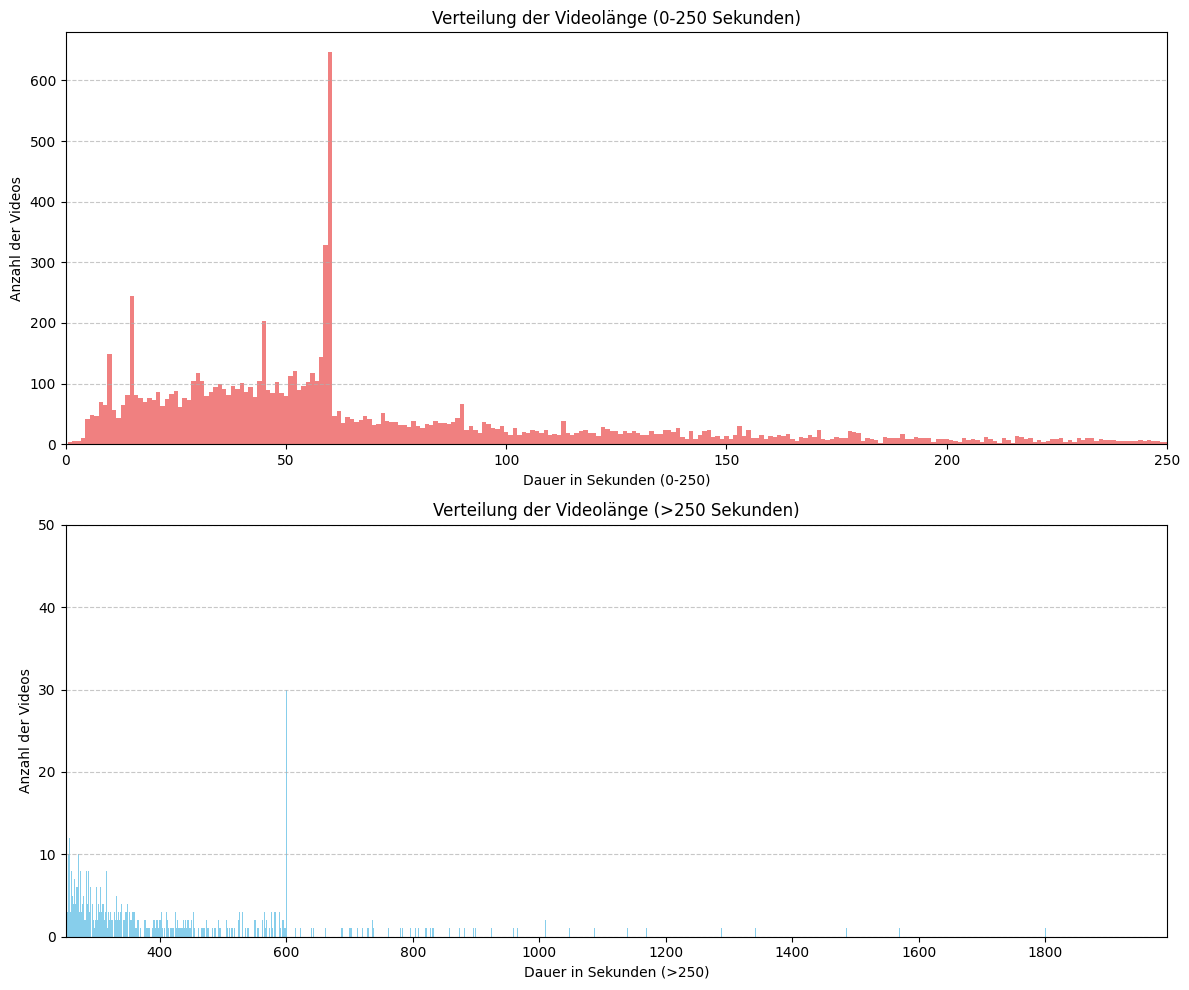

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Beispiel-DataFrame
# df = pd.read_csv('your_data.csv')
# Angenommen, df['duration'] enthält die Dauer in Sekunden

# Häufigkeiten der Dauer berechnen
duration_counts = df['duration'].value_counts().sort_index()

# Erstelle eine Figur mit zwei Subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Erster Subplot: 0 bis 250 Sekunden
axes[0].bar(duration_counts.index, duration_counts.values, width=1.0, color='lightcoral')
axes[0].set_xlim(0, 250)
axes[0].set_xlabel('Dauer in Sekunden (0-250)')
axes[0].set_ylabel('Anzahl der Videos')
axes[0].set_title('Verteilung der Videolänge (0-250 Sekunden)')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Zweiter Subplot: >250 Sekunden, mit y-Achse bis 50
axes[1].bar(duration_counts.index, duration_counts.values, width=1.0, color='skyblue')
axes[1].set_xlim(251, df['duration'].max())
axes[1].set_ylim(0, 50)  # Begrenze die y-Achse auf 50
axes[1].set_xlabel('Dauer in Sekunden (>250)')
axes[1].set_ylabel('Anzahl der Videos')
axes[1].set_title('Verteilung der Videolänge (>250 Sekunden)')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Layout anpassen
plt.tight_layout()

# Diagramme anzeigen
plt.show()

## How much is the fish?
### Wer hat die meistern Likes, Kommentare, Reposts oder Views ?

Das Skript vergleicht verschiedene TikTok-Kanäle anhand der Metriken "view_count", "like_count", "repost_count" und "comment_count". Es summiert die Werte jeder Metrik für jeden Kanal und erstellt für jede Metrik ein eigenes Balkendiagramm. Die Diagramme zeigen, wie die einzelnen Kanäle in Bezug auf diese Interaktionen abschneiden.


In [12]:
import altair as alt
import pandas as pd

# Summe für jede Metrik pro Channel berechnen
columns_to_plot = ["view_count", "like_count", "repost_count", "comment_count"]
aggregated_data = (
    df.groupby("channel")[columns_to_plot].sum().reset_index()
    .melt(id_vars="channel", var_name="metric", value_name="value")
)

# Interaktive Balkendiagramme erstellen
charts = []
for metric in columns_to_plot:
    chart = (
        alt.Chart(aggregated_data[aggregated_data["metric"] == metric])
        .mark_bar()
        .encode(
            x=alt.X("channel:O", title="Channel", sort="-y"),
            y=alt.Y("value:Q", title=f"Total {metric.capitalize()}"),
            color=alt.Color("channel:N", legend=None),
            tooltip=[
                alt.Tooltip("channel:N", title="Channel"),
                alt.Tooltip("value:Q", title=f"Total {metric.capitalize()}"),
            ],
        )
        .properties(
            title=f"Total {metric.capitalize()} by Channel",
            height=300,  # Höhe für besseres Layout
            width=1200    # Breite für bessere Darstellung
        )
    )
    # Trennelement: Linie unter dem Chart
    separator = (
        alt.Chart(pd.DataFrame({"y": [0]}))
        .mark_rule(strokeDash=[5, 5], size=1)
        .encode(y=alt.Y("y:Q", axis=None))
        .properties(height=10, width=800)
    )
    charts.extend([chart, separator])

# Subplots mit Trennelementen darstellen
final_chart = alt.vconcat(*charts).resolve_scale(color="independent")

# Konfiguration auf das gesamte Diagramm anwenden
final_chart = final_chart.configure_axis(
    labelFontSize=12,  # Schriftgröße der Achsenbeschriftung
    titleFontSize=16   # Schriftgröße des Achsentitels
)

final_chart


alt.VConcatChart(...)

In [14]:
import pandas as pd
import altair as alt
from IPython.display import display, HTML

# Annahme: df ist bereits definiert und enthält die Daten

columns_to_plot = ["view_count", "like_count", "repost_count", "comment_count"]
top_n = 50  # Für Altair-Plot
charts = []

# Altair-Plot für die Top 50 Einträge pro Metrik
for col in columns_to_plot:
    # Top 50 Einträge für die jeweilige Spalte auswählen und absteigend sortieren
    df_sorted = df.nlargest(top_n, col).sort_values(by=col, ascending=False).copy()
    # Eindeutige Labels erstellen, um Mehrfachvorkommen desselben Kanals zu unterscheiden
    df_sorted["channel_label"] = df_sorted["channel"] + " (ID:" + df_sorted["id"].astype(str) + ")"
    
    chart = (
        alt.Chart(df_sorted)
        .mark_bar()
        .encode(
            x=alt.X(f"{col}:Q", title=col.capitalize(), axis=alt.Axis(format=".0f")),
            # Y-Achse sortiert nach dem aktuellen DataFrame, der absteigend sortiert ist
            y=alt.Y("channel_label:N", title="Channel", sort=df_sorted["channel_label"].tolist()),
            color=alt.Color("channel:N", title="Channel"),
            tooltip=[
                "url", 
                "title", 
                "duration", 
                "view_count", 
                "like_count", 
                "repost_count", 
                "comment_count"
            ],
            href="url:N"  # Beim Klicken auf den Balken wird die URL geöffnet
        )
        .properties(
            title=f"Top {top_n} - {col.capitalize()}",
            width=800,
            height=600,
        )
    )
    charts.append(chart)

# Alle Subplots vertikal anordnen
final_chart = alt.vconcat(*charts)
final_chart.show()

# HTML-Tabellen für die Top 10 Einträge pro Metrik
top_n_html = 10  # Für HTML-Ausgabe
columns_for_html = ["id", "url", "title", "duration", "view_count", "like_count", "repost_count", "comment_count", "uploader"]

for col in columns_to_plot:
    # Top 10 Einträge auswählen und sortieren
    df_sorted_html = df.nlargest(top_n_html, col).sort_values(by=col, ascending=False).copy()
    df_sorted_html["channel_label"] = df_sorted_html["channel"] + " (ID:" + df_sorted_html["id"].astype(str) + ")"
    
    # Überschrift für die Tabelle
    display(HTML(f"<h3>Top {top_n_html} - {col.capitalize()}</h3>"))
    # Nur die relevanten Spalten anzeigen und "description" weglassen
    styled_table = df_sorted_html[columns_for_html].style.set_table_attributes('class="table table-striped"').hide(axis='index')
    display(styled_table)

alt.VConcatChart(...)

id,url,title,duration,view_count,like_count,repost_count,comment_count,uploader
3915,https://www.tiktok.com/@goetzfroemming/video/7284188221725035809,#aliceweidel #nurdieafd #afdwählen,13.000000,10500000,632800,44200,12600,goetzfroemming
1478,https://www.tiktok.com/@kaygottschalk/video/7173675399749078277,"Es ist Zeit, die Bürger zu entlasten! #familiensplitting #kaygottschalk #AfD #Bundestag",60.000000,6100000,400500,35600,7686,kaygottschalk
3902,https://www.tiktok.com/@markusfrohnmaier/video/7283905353270431008,Deutschland hat besseres verdient❗ #afd #politik #fürdich #baerbock #regierung #ampel,59.000000,4900000,376700,37100,4120,markusfrohnmaier
2546,https://www.tiktok.com/@sichertdeutschland/video/7226968558566182149,"Es reicht immer noch nicht! #Lauterbach will Bürger weiter schröpfen! Karl Lauterbach will der Regierung das Recht einräumen jederzeit die Beitragssätze zur #Pflegeversicherung willkürlich erhöhen zu können. Das hat er heute in einem Gesetzentwurf im #Bundestag vorgestellt. Obwohl die Reallöhne im letzten Jahr um 4% gesunken sind, will Lauterbach die Bürger immer weiter belasten. Wir werden uns dieser Politik zum Schaden der fleißigen Beitragszahler entgegenstellen.",235.000000,4200000,217500,47100,6465,sichertdeutschland
9519,https://www.tiktok.com/@alice_weidel_afd/video/7442714740855426326,"Während #Faeser „konsequentes Handeln“ hinsichtlich der Weihnachtsmärkte & deren Bedrohung durch Islamismus fordert, handelt die #AfD tatsächlich konsequent: Wir beantragen erneut, die Grenzen zu sichern! „Weidels Konter“ ist zurück - jetzt folgen und keine Ausgabe verpassen! #afd #JetztAfD #wahlkampf #aliceweidel #weidelskonter",95.000000,4100000,421400,22500,22300,alice_weidel_afd
2263,https://www.tiktok.com/@sichertdeutschland/video/7216010597622746373,Die #Wahrheit über Ricarda Lang und Karl #Lauterbach darf offenbar nicht ausgesprochen werden,28.000000,3900000,213400,21500,5726,sichertdeutschland
9894,https://www.tiktok.com/@alice_weidel_afd/video/7450487327912135958,"Dear Elon, Thank you so much for your note. The Alternative for Germany is indeed the one and only alternative for our country; our very last option. I wish you and President Donald #Trump all the best for the upcoming tenure! And also, I wish you and all the American people Merry #Christmas and a Happy New Year. #AfD #DeshalbAfD #Musk #weidel",31.000000,3500000,277000,35200,0,alice_weidel_afd
2496,https://www.tiktok.com/@mr_afd/video/7225536945919773979,Treten Sie zurück Herr #Lauterbach #Bundestag #AfD #Info #Fakten,23.000000,3200000,131300,23900,6380,mr_afd
13,https://www.tiktok.com/@roger_beckamp/video/6854255890556620038,,8.000000,3000000,307000,14600,11300,roger_beckamp
3672,https://www.tiktok.com/@sichertdeutschland/video/7277090849505217825,Das #Selbstbestimmungsgesetz der #Ampel ist nichts anderes als ein Freifahrtschein für Perrverse. Lasst uns diesen ideologischen Irrsinn beenden.💙🇩🇪,73.000000,2800000,280100,35800,5842,sichertdeutschland


id,url,title,duration,view_count,like_count,repost_count,comment_count,uploader
3915,https://www.tiktok.com/@goetzfroemming/video/7284188221725035809,#aliceweidel #nurdieafd #afdwählen,13.000000,10500000,632800,44200,12600,goetzfroemming
9519,https://www.tiktok.com/@alice_weidel_afd/video/7442714740855426326,"Während #Faeser „konsequentes Handeln“ hinsichtlich der Weihnachtsmärkte & deren Bedrohung durch Islamismus fordert, handelt die #AfD tatsächlich konsequent: Wir beantragen erneut, die Grenzen zu sichern! „Weidels Konter“ ist zurück - jetzt folgen und keine Ausgabe verpassen! #afd #JetztAfD #wahlkampf #aliceweidel #weidelskonter",95.000000,4100000,421400,22500,22300,alice_weidel_afd
1478,https://www.tiktok.com/@kaygottschalk/video/7173675399749078277,"Es ist Zeit, die Bürger zu entlasten! #familiensplitting #kaygottschalk #AfD #Bundestag",60.000000,6100000,400500,35600,7686,kaygottschalk
3902,https://www.tiktok.com/@markusfrohnmaier/video/7283905353270431008,Deutschland hat besseres verdient❗ #afd #politik #fürdich #baerbock #regierung #ampel,59.000000,4900000,376700,37100,4120,markusfrohnmaier
13,https://www.tiktok.com/@roger_beckamp/video/6854255890556620038,,8.000000,3000000,307000,14600,11300,roger_beckamp
10018,https://www.tiktok.com/@alice_weidel_afd/video/7454602923188817184,"Ich wünsche Ihnen und Ihrer Familie einen guten Rutsch und ein erfolgreiches und gesundes neues Jahr. Für unser Land wird es ein entscheidendes Jahr. Schon jetzt bedanke ich mich für Ihre Unterstützung bei all den Herausforderungen, die #2025 vor uns liegen - und die wir gemeinsam meistern werden. #Silvester #Neujahr #Weidel #AfD #NurnochAfD #JetztAfD",193.000000,2500000,287700,16700,16300,alice_weidel_afd
3672,https://www.tiktok.com/@sichertdeutschland/video/7277090849505217825,Das #Selbstbestimmungsgesetz der #Ampel ist nichts anderes als ein Freifahrtschein für Perrverse. Lasst uns diesen ideologischen Irrsinn beenden.💙🇩🇪,73.000000,2800000,280100,35800,5842,sichertdeutschland
9894,https://www.tiktok.com/@alice_weidel_afd/video/7450487327912135958,"Dear Elon, Thank you so much for your note. The Alternative for Germany is indeed the one and only alternative for our country; our very last option. I wish you and President Donald #Trump all the best for the upcoming tenure! And also, I wish you and all the American people Merry #Christmas and a Happy New Year. #AfD #DeshalbAfD #Musk #weidel",31.000000,3500000,277000,35200,0,alice_weidel_afd
9265,https://www.tiktok.com/@alice_weidel_afd/video/7436285325305007382,"Statt mit einer Mehrheit aus #AfD, #CDU/#CSU & #FDP Gesetze im Sinne der Bürger zu ändern oder zu beschließen, lähmt die Union den parlamentarischen Betrieb. Es besteht offenkundig gar kein Wille, zum Vorteil der Menschen im Land zu handeln. Deshalb: Jede Stimme für die AfD - um bürgerliche Mehrheiten und damit echte Veränderung zu ermöglichen! #JetztAfD #aliceweidel #afd #fy #fyp #fürdich",90.000000,2300000,224600,14600,12400,alice_weidel_afd
8242,https://www.tiktok.com/@alice_weidel_afd/video/7408907811129724193,"Am Sonntag #AfD - für die Zukunft nicht nur in #Sachsen und #Thüringen, sondern für die Zukunft in ganz #Deutschland! Mit beiden Stimmen AfD! #Jetzterstrechtafd #deshalbafd #jetztafd",32.000000,2200000,218400,11700,17800,alice_weidel_afd


id,url,title,duration,view_count,like_count,repost_count,comment_count,uploader
2546,https://www.tiktok.com/@sichertdeutschland/video/7226968558566182149,"Es reicht immer noch nicht! #Lauterbach will Bürger weiter schröpfen! Karl Lauterbach will der Regierung das Recht einräumen jederzeit die Beitragssätze zur #Pflegeversicherung willkürlich erhöhen zu können. Das hat er heute in einem Gesetzentwurf im #Bundestag vorgestellt. Obwohl die Reallöhne im letzten Jahr um 4% gesunken sind, will Lauterbach die Bürger immer weiter belasten. Wir werden uns dieser Politik zum Schaden der fleißigen Beitragszahler entgegenstellen.",235.000000,4200000,217500,47100,6465,sichertdeutschland
3915,https://www.tiktok.com/@goetzfroemming/video/7284188221725035809,#aliceweidel #nurdieafd #afdwählen,13.000000,10500000,632800,44200,12600,goetzfroemming
794,https://www.tiktok.com/@rene_springer/video/7113195751080987909,Rente mit 57 für Ukrainer? Es ist viel schlimmer! #tiktok #viral #fyp #foryou #like #follow #AfD #Bundestag,192.000000,2000000,205000,39200,7967,rene_springer
3216,https://www.tiktok.com/@roger_beckamp/video/7252341905000828187,Deutsches Geld für Einheimische - nicht für Afrika! #AfD #patriotismus #diegrünenmüssenweg #patriotismus🇩🇪💙,24.000000,983200,90600,37100,1420,roger_beckamp
3902,https://www.tiktok.com/@markusfrohnmaier/video/7283905353270431008,Deutschland hat besseres verdient❗ #afd #politik #fürdich #baerbock #regierung #ampel,59.000000,4900000,376700,37100,4120,markusfrohnmaier
3672,https://www.tiktok.com/@sichertdeutschland/video/7277090849505217825,Das #Selbstbestimmungsgesetz der #Ampel ist nichts anderes als ein Freifahrtschein für Perrverse. Lasst uns diesen ideologischen Irrsinn beenden.💙🇩🇪,73.000000,2800000,280100,35800,5842,sichertdeutschland
1478,https://www.tiktok.com/@kaygottschalk/video/7173675399749078277,"Es ist Zeit, die Bürger zu entlasten! #familiensplitting #kaygottschalk #AfD #Bundestag",60.000000,6100000,400500,35600,7686,kaygottschalk
2534,https://www.tiktok.com/@sichertdeutschland/video/7226665218867350789,"#Lauterbach findet es ""gerecht"", dass #Pflegebedürftige ihr #Haus verkaufen müssen, aber der Staat jedes Jahr Abermilliarden an China, Indien, die Ukraine, Syrien und sonstwohin verschenkt. Ich rechne Herrn Lauterbach vor, mit wie vielen Milliarden Pflegebedürftige unterstützt werden könnten, wenn wir das Steuergeld für diejenigen nutzen, die es eingezahlt haben!",399.000000,2000000,87100,35200,6743,sichertdeutschland
9894,https://www.tiktok.com/@alice_weidel_afd/video/7450487327912135958,"Dear Elon, Thank you so much for your note. The Alternative for Germany is indeed the one and only alternative for our country; our very last option. I wish you and President Donald #Trump all the best for the upcoming tenure! And also, I wish you and all the American people Merry #Christmas and a Happy New Year. #AfD #DeshalbAfD #Musk #weidel",31.000000,3500000,277000,35200,0,alice_weidel_afd
339,https://www.tiktok.com/@rene_springer/video/7054511688250363141,751€ Durschnittsrente für Frauen mit drei Kindern. 944€ für einen arbeitslosen Afghanen ist Hamburg. Ist das gerecht? #Bundestag #viral #tiktok #fyp #foryou #fürdich #foryourpage #follow #fy #like,46.000000,2200000,97000,31600,5832,rene_springer


id,url,title,duration,view_count,like_count,repost_count,comment_count,uploader
9519,https://www.tiktok.com/@alice_weidel_afd/video/7442714740855426326,"Während #Faeser „konsequentes Handeln“ hinsichtlich der Weihnachtsmärkte & deren Bedrohung durch Islamismus fordert, handelt die #AfD tatsächlich konsequent: Wir beantragen erneut, die Grenzen zu sichern! „Weidels Konter“ ist zurück - jetzt folgen und keine Ausgabe verpassen! #afd #JetztAfD #wahlkampf #aliceweidel #weidelskonter",95.000000,4100000,421400,22500,22300,alice_weidel_afd
8242,https://www.tiktok.com/@alice_weidel_afd/video/7408907811129724193,"Am Sonntag #AfD - für die Zukunft nicht nur in #Sachsen und #Thüringen, sondern für die Zukunft in ganz #Deutschland! Mit beiden Stimmen AfD! #Jetzterstrechtafd #deshalbafd #jetztafd",32.000000,2200000,218400,11700,17800,alice_weidel_afd
10018,https://www.tiktok.com/@alice_weidel_afd/video/7454602923188817184,"Ich wünsche Ihnen und Ihrer Familie einen guten Rutsch und ein erfolgreiches und gesundes neues Jahr. Für unser Land wird es ein entscheidendes Jahr. Schon jetzt bedanke ich mich für Ihre Unterstützung bei all den Herausforderungen, die #2025 vor uns liegen - und die wir gemeinsam meistern werden. #Silvester #Neujahr #Weidel #AfD #NurnochAfD #JetztAfD",193.000000,2500000,287700,16700,16300,alice_weidel_afd
10103,https://www.tiktok.com/@alice_weidel_afd/video/7457514479530675478,Unterstütze uns im Wahlkampf und erhalte als Dankeschön die Chance auf eines von drei signierten #TeamAlice-Shirts pro Woche! Jetzt auf alice-weidel.de/unterstuetzen anmelden und mitmachen! #AfD #aliceweidel #teamalice #wahlkampf #jetztafd #alternativefürdeutschland,30.000000,1500000,127300,12800,13600,alice_weidel_afd
2029,https://www.tiktok.com/@muenzenmaier/video/7207815731763760390,Skandalurteil - Bewährung für Vergewaltiger #migration #ausländer #kriminalitätindeutschland #urteil #flüchtlinge #flüchtlingskrise #afd,40.000000,1700000,142200,19200,13300,muenzenmaier
3915,https://www.tiktok.com/@goetzfroemming/video/7284188221725035809,#aliceweidel #nurdieafd #afdwählen,13.000000,10500000,632800,44200,12600,goetzfroemming
9265,https://www.tiktok.com/@alice_weidel_afd/video/7436285325305007382,"Statt mit einer Mehrheit aus #AfD, #CDU/#CSU & #FDP Gesetze im Sinne der Bürger zu ändern oder zu beschließen, lähmt die Union den parlamentarischen Betrieb. Es besteht offenkundig gar kein Wille, zum Vorteil der Menschen im Land zu handeln. Deshalb: Jede Stimme für die AfD - um bürgerliche Mehrheiten und damit echte Veränderung zu ermöglichen! #JetztAfD #aliceweidel #afd #fy #fyp #fürdich",90.000000,2300000,224600,14600,12400,alice_weidel_afd
13,https://www.tiktok.com/@roger_beckamp/video/6854255890556620038,,8.000000,3000000,307000,14600,11300,roger_beckamp
2639,https://www.tiktok.com/@sichertdeutschland/video/7231299505574907162,"38 Milliarden für die Ukraine jedes Jahr?! 🤯 Hierzulande fehlt an allen Ecken und Enden das #Geld . Die Bürger müssen das Bisschen, das von ihrem Lohn bleibt, zusammenkratzen, um noch über die Runden zu kommen. Aber für die #Ukraine spielt Geld keine Rolle. Wir haben zuallererst eine Verantwortung gegenüber den Bürgern im eigenen Land zu tragen!",235.000000,2100000,122100,28500,9682,sichertdeutschland
794,https://www.tiktok.com/@rene_springer/video/7113195751080987909,Rente mit 57 für Ukrainer? Es ist viel schlimmer! #tiktok #viral #fyp #foryou #like #follow #AfD #Bundestag,192.000000,2000000,205000,39200,7967,rene_springer


_____________

### Veröffentlichungen pro Tag 

Das Skript verarbeitet Daten zu Videoveröffentlichungen, wandelt Zeitstempel in jahres- und tagesbezogene Formate um und gruppiert sie nach Jahr, Tag und Kanal, um die Anzahl der Veröffentlichungen zu zählen. Anschließend erstellt es ein facettiertes Balkendiagramm, das die tägliche Veröffentlichungsaktivität pro Jahr und Kanal visualisiert.

Unter den Ausgewählten Kanälen lassen sich somit viele Trends in der Nutzung abbilden.

In [30]:
import pandas as pd
import altair as alt

# Zeilenbegrenzung deaktivieren
alt.data_transformers.disable_max_rows()

# Zeitbezogene Spalten erstellen
df["datetime"] = pd.to_datetime(df["timestamp"], unit='s')
df["year"] = df["datetime"].dt.year
df["day"] = df["datetime"].dt.floor('D')

# Gruppierung: Anzahl der Videos pro Tag und Kanal zählen
df_counts = (
    df.groupby(["year", "day", "channel"])
      .size()
      .reset_index(name='count')
)

# Sicherstellen, dass 'day' im richtigen Format vorliegt
df_counts["day"] = pd.to_datetime(df_counts["day"])

# Altair-Chart erstellen: Subplot für jedes Jahr mit jahresspezifischer x-Achse
chart = alt.Chart(df_counts).mark_bar().encode(
    x=alt.X("day:T", 
            title="Datum", 
            scale=alt.Scale(nice=False)  # Zeigt die spezifischen Tage jedes Jahres
           ),
    y=alt.Y("sum(count):Q", title="Anzahl Veröffentlichungen"),
    color=alt.Color("channel:N", title="Kanal", legend=alt.Legend(orient="right", labelFontSize=12, titleFontSize=14)),
    tooltip=[
        alt.Tooltip("day:T", title="Datum"),
        alt.Tooltip("channel:N", title="Kanal"),
        alt.Tooltip("sum(count):Q", title="Veröffentlichungen")
    ]
).properties(
    width=800  # Breiterer Plot
).facet(
    row=alt.Row("year:N", title="Jahr")
).resolve_scale(
    x="independent",  # Unabhängige x-Achse für jedes Jahr
    y="independent"
)

chart


alt.FacetChart(...)